In [1]:
from tutorials.utils.tutorial_utils import setup_notebook
setup_notebook()
import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '../../nuplan/dataset')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '../../nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '../../nuplan/dataset/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

For one LQR scene, get the following information:
- current_ego_pose_gb
- current_ego_pose
- future_ego_pose
- current_neighbour_pos
- future_neighbour_pos
- current_lane

In [2]:
from nuplan.planning.script.builders.scenario_building_builder import build_scenario_builder
from nuplan.planning.script.builders.scenario_filter_builder import build_scenario_filter
from nuplan.planning.script.builders.worker_pool_builder import build_worker

### set up config file - edit in the config access to change ###
import hydra
CONFIG_PATH = "../nuplan/planning/script/config/common/myconfigs"
CONFIG_NAME = "scenario_access"
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[])
###

### create all scenario objects as specified in config file ###
scenario_builder = build_scenario_builder(cfg)
scenario_filter = build_scenario_filter(cfg.scenario_filter)
worker = build_worker(cfg)
scenarios = scenario_builder.get_scenarios(scenario_filter, worker) # List[AbstractScenario]

In [3]:
from math import sqrt
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.common.actor_state.state_representation import TimeDuration
import numpy as np

class LQRData():
    
    def __init__(self, scenario, closest=5):
        self.s = scenario
        
        self.data = {} # to be used for LQR
        
        self.duration = self.s.duration_s # TimeDuration Object in seconds
        self.num_frames = self.s.get_number_of_iterations()
        self.scenario_type = self.s.scenario_type
        
        self.n = closest
        self.closest_neighbors_id = []
    
    def populate_data(self):
        self.data['current_ego_pos_gb'] = self.get_current_ego_pos_gb()
        self.data['current_ego_pos'] = self.get_current_ego_pos()
        self.data['future_ego_pos'] = self.get_future_ego_pos()
        self.data['current_neighbor_pos'] = self.get_current_neighbor_pos()
        self.data['future_neighbor_pos'] = self.get_future_neighbor_pos_id_consistent()
        self.data['current_lane'] = self.get_current_lane()
    
    def get_current_ego_pos_gb(self):
        return self.get_xy_from_egostate(self.s.initial_ego_state)
    
    def get_current_ego_pos(self):
        return (0, 0)
    
    def get_future_ego_pos(self):
        future_ego_pos = []
        for ego in self.s.get_ego_future_trajectory(0, self.duration.time_s):
            future_ego_pos.append(self.get_xy_from_egostate(ego))
        return np.asarray(future_ego_pos)
        
    def get_current_neighbor_pos(self):
        
        neighbors = self.s.initial_tracked_objects.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE)
        
        neighbors = sorted(neighbors, key=lambda ag:self.dist(self.data['current_ego_pos_gb'], 
                                                               self.get_xy_from_agent(ag)))
        assert(self.n <= len(neighbors))
        near_neighbors = neighbors[:self.n]
        self.closest_neighbors_id = [x.track_token for x in near_neighbors]
        return np.asarray([self.get_xy_from_agent(ag) for ag in near_neighbors])
    
#     def get_future_neighbor_pos_nearest_n(self):
        
#         frames = []
#         for detection_track in self.s.get_future_tracked_objects(0, self.duration.time_s):
#             tracked_objs = detection_track.tracked_objects
#             tracked_objs = sorted(tracked_objs, key=lambda ag:self.dist(self.data['current_ego_pos_gb'],
#                                                                   self.get_xy_from_agent(ag)))
#             near_objs = tracked_objs[:self.n]
            
#         return frames
    
    def get_future_neighbor_pos_id_consistent(self):
        
        frames = []
        
        for detection_track in self.s.get_future_tracked_objects(0, self.duration.time_s):
            tracked_objs = detection_track.tracked_objects
            
            interest_objs = []
            for obj in tracked_objs:
                if obj.track_token in self.closest_neighbors_id:
                    interest_objs.append(self.get_xy_from_agent(obj))
            
            assert(len(interest_objs) == self.n)
            frames.append(interest_objs)
            
        return np.asarray(frames)
    
    def get_current_lane(self):
        ##### CHANGE THIS TO MAKE SENSE LATER #####
        
        future_ego_pos = []
        for ego in self.s.get_expert_ego_trajectory():
            future_ego_pos.append(self.get_xy_from_egostate(ego))
        return np.asarray(future_ego_pos)
    
    def get_xy_from_agent(self, agent):
        return (agent.center.x, agent.center.y)
    
    def get_xy_from_egostate(self, ego):
        return ego.waypoint._oriented_box.center.x, ego.waypoint._oriented_box.center.y
    
    def dist(self, a, b):
        return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [17]:
s0_ = scenarios[0]
s0 = LQRData(scenarios[0])
s0.populate_data()

In [18]:
s0.data.keys()
# ['current_ego_pos_gb', 'current_ego_pos', 'future_ego_pos', 'current_neighbor_pos',
# 'future_neighbor_pos', 'current_lane']
print(s0.data['future_ego_pos'].shape)
print(s0.data['future_neighbor_pos'].shape)
print(s0.data['current_lane'].shape)

(149, 2)
(149, 5, 2)
(151, 2)


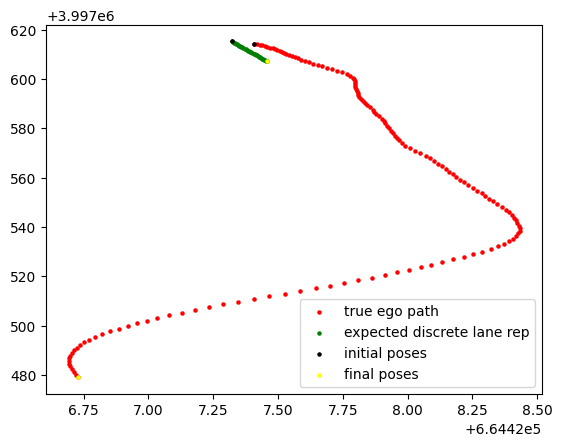

In [20]:
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import SemanticMapLayer
from matplotlib import pyplot as plt

def plot_closest_lane(s0):
    pose = s0.data['current_ego_pos_gb']
    point = Point2D(pose[0], pose[1])

    lane = s0_.map_api.get_one_map_object(point, SemanticMapLayer.LANE)
    dlane = lane.baseline_path.discrete_path
    discrete_lane_x, discrete_lane_y = [pt.x for pt in dlane], [pt.y for pt in dlane]

    plt.scatter(s0.data['future_ego_pos'][:, 0], s0.data['future_ego_pos'][:, 1], color = 'r', s=5, label='true ego path')
    plt.scatter(discrete_lane_x, discrete_lane_y, color='g', s=5, label='expected discrete lane rep')

    # plots initial pose in black
    plt.scatter(s0.data['future_ego_pos'][:1, 0], s0.data['future_ego_pos'][:1, 1], color = 'black', s=5, label='initial poses')
    plt.scatter(discrete_lane_x[:1], discrete_lane_y[:1], color='black', s=5)

    plt.scatter(discrete_lane_x[-1], discrete_lane_y[-1], color='yellow', s=5, label='final poses')
    plt.scatter(s0.data['future_ego_pos'][-1, 0], s0.data['future_ego_pos'][-1, 1], color='yellow', s=5)

    plt.legend()


s = LQRData(scenarios[0])
s.populate_data()
plot_closest_lane(s)

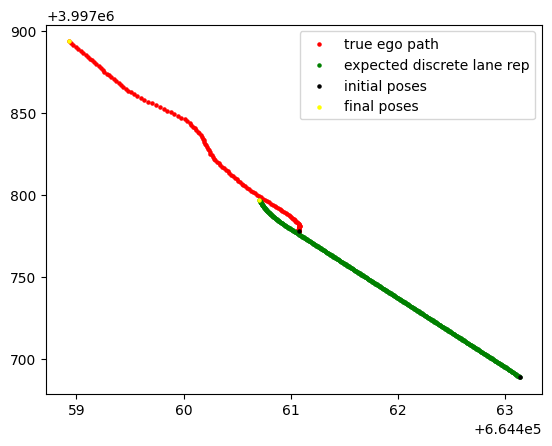

In [21]:
s = LQRData(scenarios[1])
s.populate_data()
plot_closest_lane(s)

#### It seems like the closest lane to the initial ego pose starts quite far from it

Find longer (multi-edge) discrete lane paths using breadth first search

In [6]:
from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.maps.abstract_map_objects import LaneGraphEdgeMapObject
from typing import List, Tuple
from nuplan.planning.simulation.planner.utils.breadth_first_search import BreadthFirstSearch
import math

# get route plan from map
route_roadblocks_ids = s0_.get_route_roadblock_ids()

route_roadblocks = []
for id_ in route_roadblocks_ids:
    block = s0_.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK)
    block = block or s0_.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK_CONNECTOR)
    route_roadblocks.append(block)

# candidate lane IDs
candidate_lane_edge_ids = [edge.id for block in route_roadblocks if block for edge in block.interior_edges]

def get_starting_edge(ego_state: EgoState) -> LaneGraphEdgeMapObject:
    
    starting_edge = None
    closest_dist = math.inf
    found_on_roadblock = False
    for edge in route_roadblocks[0].interior_edges + route_roadblocks[1].interior_edges:
        if edge.contains_point(ego_state.center):
            starting_edge = edge
            found_on_roadblock = True
            break
        # case ego does not start on a road block
        distance = edge.polygon.distance(ego_state.car_footprint.geometry)
        if distance < closest_dist:
            starting_edge = edge
            closest_dist = distance
    
    if not found_on_roadblock:
        print('Picking closest approx')
    return starting_edge

def bfs(ego_state: EgoState) -> Tuple[List[LaneGraphEdgeMapObject], bool]:
    starting_edge = get_starting_edge(ego_state)
    graph_search = BreadthFirstSearch(starting_edge, candidate_lane_edge_ids)
    offset = 1 if starting_edge.get_roadblock_id() == route_roadblocks[1].id else 0
    route_plan, path_found = graph_search.search(route_roadblocks[-1], len(route_roadblocks[offset:]))
    if not path_found:
        logger.warning('Path not found')
    return route_plan, path_found

current_lane_path, found = bfs(s0_.initial_ego_state)
assert(found == True)

In [7]:
route = []
for lane in current_lane_path:
    route += lane.baseline_path.discrete_path

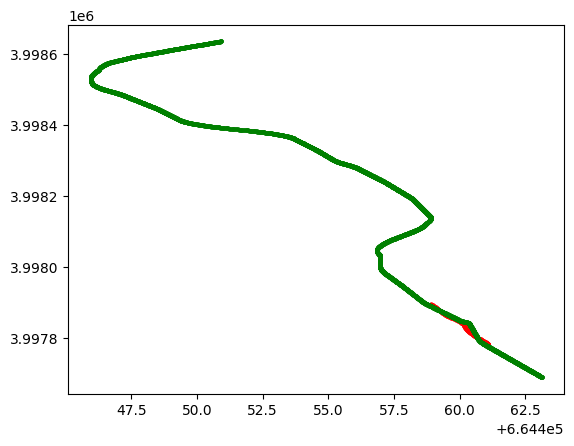

In [8]:
discrete_lane_x, discrete_lane_y = [pt.x for pt in route], [pt.y for pt in route]

plt.scatter(s0.data['future_ego_pos'][:, 0], s0.data['future_ego_pos'][:, 1], color = 'r', s=5)
plt.scatter(discrete_lane_x, discrete_lane_y, color='g', s=5)

both the initial and final state are different between the path finding and the goal_state

In [9]:
s0_.initial_ego_state.center

StateSE2(x=664461.0721685191, y=3997777.899627016, heading=1.5878035491762825)

In [10]:
discrete_lane_x[0], discrete_lane_y[0]

(664463.1335571983, 3997688.5273141917)

In [11]:
s0.data['future_ego_pos'][-1, 0], s0.data['future_ego_pos'][-1, 1]

(664458.927031184, 3997893.764858045)

In [12]:
discrete_lane_x[-1], discrete_lane_y[-1]

(664450.9222868871, 3998635.2032145886)

In [13]:
##### Conclude that get_expert_ego_trajectory and get_ego_future_trajectory are almost the same thing #####

# def get_xy_from_statelist(states):
#     coords = np.asarray([(pt.x, pt.y) for pt in states])
#     return (coords[:, 0], coords[:, 1])

# def get_xy_from_egostatelist(ego_states):
#     coords = np.asarray([(pt.center.x, pt.center.y) for pt in ego_states])
#     return (coords[:, 0], coords[:, 1])

# x_expert, y_expert = get_xy_from_egostatelist(s0_.get_expert_ego_trajectory())
# x_future, y_future = get_xy_from_egostatelist(s0_.get_ego_future_trajectory(0, s0.duration.time_s))

# plt.scatter(x_expert, y_expert, color = 'r', s=5)
# plt.scatter(x_future, y_future, color='g', s=5)